# imports

In [2]:
import copy
import warnings
import pickle
warnings.filterwarnings('ignore')
import os

import hydra
from omegaconf import DictConfig

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from utils.data import load_Ford_A, transform_data, MyDataset
from models.models import LSTM_net, TS2VecClassifier

from utils.attacks import ifgsm_procedure
from utils.utils import save_experiment, load_disc_model
from utils.discrim_training import HideAttackExp
from utils.config import get_attack, load_disc_config
from utils.attacks import (fgsm_disc_attack, fgsm_attack, fgsm_reg_attack, 
simba_binary, simba_binary_reg, simba_binary_disc_reg)
from utils.data import transform_data, MyDataset

from utils.TS2Vec.datautils import load_UCR

# Data loading

In [11]:
X_train, y_train, X_test, y_test = load_UCR('Strawberry')
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])


X_train, X_test, y_train, y_test = transform_data(X_train, X_test, y_train, y_test)

In [19]:
bad_datasets = [
        'AllGestureWiimoteX',
        'AllGestureWiimoteY',
        'AllGestureWiimoteZ',
        'BME',
        'Chinatown',
        'Crop',
        'EOGHorizontalSignal',
        'EOGVerticalSignal',
        'Fungi',
        'GestureMidAirD1',
        'GestureMidAirD2',
        'GestureMidAirD3',
        'GesturePebbleZ1',
        'GesturePebbleZ2',
        'GunPointAgeSpan',
        'GunPointMaleVersusFemale',
        'GunPointOldVersusYoung',
        'HouseTwenty',
        'InsectEPGRegularTrain',
        'InsectEPGSmallTrain',
        'MelbournePedestrian',
        'PickupGestureWiimoteZ',
        'PigAirwayPressure',
        'PigArtPressure',
        'PigCVP',
        'PLAID',
        'PowerCons',
        'Rock',
        'SemgHandGenderCh2',
        'SemgHandMovementCh2',
        'SemgHandSubjectCh2',
        'ShakeGestureWiimoteZ',
        'SmoothSubspace',
        'UMD'
    ]



In [24]:
all_datasets = os.listdir(f'data/TS2Vec/UCR')
skip_list = ['Missing_value_and_variable_length_datasets_adjusted', 'UCRArchive_2018.zip', 'Descriptions',
                'Multivariate2018_arff.zip', 'EigenWorms', 'Images']

for dataset in all_datasets:
    if dataset in bad_datasets or dataset in skip_list:
        continue
    X_train, y_train, X_test, y_test = load_UCR(dataset)
    if len(X_train) > 1000:
        print(dataset, len(X_train), len(X_test))

PhalangesOutlinesCorrect 1800 858
NonInvasiveFetalECGThorax1 1800 1965
FordB 3636 810
ElectricDevices 8926 7711
FordA 3601 1320
NonInvasiveFetalECGThorax2 1800 1965


In [11]:
X_train.shape, X_test.shape, y_train.shape

((28, 286), (28, 286), (28,))

In [12]:
X_train, X_test, y_train, y_test = load_Ford_A()
X_train.shape, X_test.shape, y_train.shape

((3601, 500), (1320, 500), (3601,))

In [5]:
path = 'checkpoints/Coffee/model_1_Coffee_metrics.pickle'

with open(path, 'rb') as f:
    results_train = pickle.load(f)

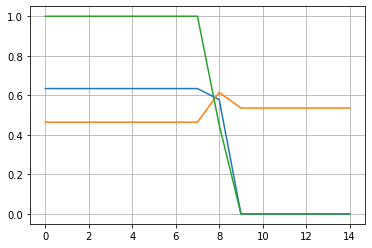

In [11]:
plt.plot(results_train['test']['f1'], label='f1')
plt.plot(results_train['test']['accuracy'], label='accuracy')
plt.plot(results_train['test']['balance'], label='balance')
plt.grid()
plt.show()

# resave ts2vec

In [3]:
#all_weights = sorted(os.listdir('checkpoints/TS2Vec/emb_models/UCR'))

glob_dataset_name = 'UCR'
dataset_name = 'FordA'
adv = ''

model = TS2VecClassifier()

for model_id in range(5):
    
    path_emb = f'checkpoints/TS2Vec/emb_models{adv}/{glob_dataset_name}/{dataset_name}_{model_id}.pt'
    path_head = f'checkpoints/TS2Vec/class_models{adv}/{glob_dataset_name}/{dataset_name}_{model_id}.pt'
    path_save = f'checkpoints/TS2Vec/entire_model/{glob_dataset_name}/{dataset_name}/model_{model_id}_{dataset_name}.pth'

    model.load_old(path_emb, path_head)

    path = '/'.join(path_save.split('/')[:-1])
    print(path)

    if not os.path.isdir(path):
        os.makedirs(path)
    

    model.save(path_save)


checkpoints/TS2Vec/entire_model/UCR/FordA
checkpoints/TS2Vec/entire_model/UCR/FordA
checkpoints/TS2Vec/entire_model/UCR/FordA
checkpoints/TS2Vec/entire_model/UCR/FordA
checkpoints/TS2Vec/entire_model/UCR/FordA


# check ts2vec metrics

In [2]:
import os

import numpy as np
import torch
from torch import nn

from utils.TS2Vec.datautils import load_UCR
from models.models import  TS2VecClassifier
from utils.data import transform_data, MyDataset

In [3]:
def req_grad(model: nn.Module, state: bool = True) -> None:
    """Set requires_grad of all model parameters to the desired value.

    :param model: the model
    :param state: desired value for requires_grad
    """
    for param in model.parameters():
        param.requires_grad_(state)

In [6]:
model_id = 0
dataset_name = 'Coffee'
disc_model_name = 'fgsm_reg_attack_eps=0.2_alpha=0.01_nsteps=4'
glob_dataset_name = 'UCR'
adv = ''

X_train, y_train, X_test, y_test = load_UCR(dataset_name)

print(X_test.shape)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

print(X_test.shape)

X_train, X_test, y_train, y_test = transform_data(X_train, X_test, y_train, y_test, slice_data=False)

# X_train = np.where(np.isnan(X_train), 0, X_train)
# X_test = np.where(np.isnan(X_test), 0, X_test)

# X_train, y_train = torch.from_numpy(X_train).to(torch.float), torch.from_numpy(y_train).to(torch.float)
# X_test, y_test = torch.from_numpy(X_test).to(torch.float), torch.from_numpy(y_test).to(torch.float)

print(X_test.shape, y_test.shape)

model = TS2VecClassifier()
path_save = f'checkpoints/TS2Vec/entire_model/{glob_dataset_name}/{dataset_name}/model_{model_id}_{dataset_name}.pth'
model.load(path_save)
model = model.eval()


disc_model = TS2VecClassifier(dropout=0.1, n_layers=1, dropout_ts2vec=0.0)
path_save = f'results/{dataset_name}/IFGSM/Discriminator_pickle/{disc_model_name}/{model_id}.pt'
disc_model.load(path_save)
disc_model = disc_model.eval()
req_grad(model, state=True)

y_pred = disc_model(X_test.unsqueeze(-1))
disc_prediction = torch.mean(y_pred.to(float).cpu())
disc_prediction

(28, 286, 1)
(28, 286)
torch.Size([28, 286]) torch.Size([28])


tensor(0.0496, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [14]:
disc_model

TS2VecClassifier(
  (emd_model): AveragedModel(
    (module): TSEncoder(
      (input_fc): Linear(in_features=1, out_features=64, bias=True)
      (feature_extractor): DilatedConvEncoder(
        (net): Sequential(
          (0): ConvBlock(
            (conv1): SamePadConv(
              (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
            )
            (conv2): SamePadConv(
              (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
            )
          )
          (1): ConvBlock(
            (conv1): SamePadConv(
              (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
            )
            (conv2): SamePadConv(
              (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
            )
          )
          (2): ConvBlock(
            (conv1): SamePadConv(
              (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
  

In [3]:
X_test.unsqueeze(-1).shape

torch.Size([1320, 500, 1])

In [19]:
y_pred = model(X_test.unsqueeze(-1))
y_pred_real = (y_pred.flatten() > 0.5).to(int).cpu()

acc = torch.mean((y_pred_real == y_test).to(float))
acc

tensor(0.9295, dtype=torch.float64)

In [20]:
y_pred = disc_model(X_test.unsqueeze(-1))
disc_prediction = torch.mean(y_pred.to(float).cpu())
disc_prediction

tensor(0.1055, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [11]:
y_pred = model(X_test.unsqueeze(-1))
y_pred_real = (y_pred.flatten() > 0.5).to(int).cpu()
acc = torch.mean((y_pred_real == y_test).to(float))
acc

tensor(0.8929, dtype=torch.float64)

In [16]:
y_pred = model(X_train.unsqueeze(-1))
y_pred_real = (y_pred > 0.5).to(int)

acc = torch.mean((y_pred_real == y_train).to(float))
acc

tensor(0.5000, dtype=torch.float64)

# Resave disc models

In [3]:
path = 'results/Ford_A/IFGSM/Discriminator_pickle'
folders = sorted(os.listdir(path))
folders = [fold for fold in folders if '.pickle' not in fold]


for fold in tqdm(folders):
    path_loc = path + '/' + fold
    pickles = sorted(os.listdir(path_loc))
    pickles = [file for file in pickles if 'log' not in file or 'pt' in file]

    for pickle_file in pickles:
        try:
            with open(path_loc + '/' + pickle_file, 'rb') as f:
                experiment = pickle.load(f)
            
            model_weights_name = path_loc + '/' + pickle_file.replace('pickle', 'pt')
            torch.save(experiment.disc_model.state_dict(), model_weights_name)

            logs_name =  path_loc + '/' + pickle_file.replace('.pickle', '_logs.pickle')
            with open(logs_name, 'wb') as f:
                pickle.dump(experiment.dict_logging, f)
        except:
            print('FAIL', path_loc, pickle_file)

  0%|          | 0/16 [00:00<?, ?it/s]

FAIL results/Ford_A/IFGSM/Discriminator_pickle/fgsm_attack_eps=0.005_nsteps=10 0.pt
FAIL results/Ford_A/IFGSM/Discriminator_pickle/fgsm_attack_eps=0.005_nsteps=10 1.pt
FAIL results/Ford_A/IFGSM/Discriminator_pickle/fgsm_attack_eps=0.005_nsteps=10 2.pt
FAIL results/Ford_A/IFGSM/Discriminator_pickle/fgsm_attack_eps=0.005_nsteps=10 3.pt
FAIL results/Ford_A/IFGSM/Discriminator_pickle/fgsm_attack_eps=0.005_nsteps=10 4.pt
FAIL results/Ford_A/IFGSM/Discriminator_pickle/fgsm_attack_eps=0.005_nsteps=10 5.pt
FAIL results/Ford_A/IFGSM/Discriminator_pickle/fgsm_attack_eps=0.005_nsteps=10 6.pt
FAIL results/Ford_A/IFGSM/Discriminator_pickle/fgsm_attack_eps=0.005_nsteps=10 7.pt
FAIL results/Ford_A/IFGSM/Discriminator_pickle/fgsm_attack_eps=0.005_nsteps=10 8.pt
FAIL results/Ford_A/IFGSM/Discriminator_pickle/fgsm_attack_eps=0.005_nsteps=10 9.pt
FAIL results/Ford_A/IFGSM/Discriminator_pickle/fgsm_attack_eps=0.01_nsteps=10 0.pt
FAIL results/Ford_A/IFGSM/Discriminator_pickle/fgsm_attack_eps=0.01_nsteps=10

In [2]:
import numpy as np
np.geomspace(0.001, 1.0, 5)

array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])